In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='docEmbeddings_win2_load_all.d2v'

In [4]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_win2_load_all.d2v


In [7]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([ 1.9926796 , -0.95616704, -0.41943806,  1.05640149, -0.17750672,
       -0.22473556, -1.14849627, -1.04512095,  0.72278821, -0.26906219,
       -0.12173071,  0.27951074,  0.85554093,  1.4066658 , -0.66658169,
       -3.5733881 ,  0.61995304, -2.23058319, -0.13402276,  2.12668133,
       -0.35180882, -0.27377269,  0.54994392, -1.48118317, -1.4935751 ,
       -1.68159318,  0.34006077,  2.6541965 , -0.45972574, -0.43201742,
        0.3170231 , -1.63518965,  2.0632391 ,  1.46774471, -0.95080161,
        0.16261423,  1.81780541,  0.94335526, -0.02719352,  0.66872084,
        0.53617448,  0.2284466 ,  1.14089978, -1.53023636, -0.30838454,
        1.86624837, -0.64276832,  0.49743181, -0.53058469,  1.06889701,
        0.34412953,  0.14060664,  1.23631251,  0.41249499, -0.50394237,
        0.92049599,  0.2226413 , -0.11276353, -0.56527591,  0.82244128,
       -0.99196661, -0.42952666, -0.88652813,  0.43424979, -1.98911691,
        1.09482539, -2.45888305,  1.73302603,  2.20067   , -0.60

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [29]:
# this is the 4 layer full-connected nerual network model
model = nn_baseline_model(TEXT_INPUT_DIM, GENE_INPUT_DIM, GENE_INPUT_DIM)
model.summary()

C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal", activation="relu", input_dim=250)`
  model.add(Dense(256, input_dim=Text_INPUT_DIM+ Gene_INPUT_DIM + Variation_INPUT_DIM, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  model.add(Dense(256, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  model.add(Dense(80, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:33: UserWarning: Update your `De

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               64256     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 80)                20560     
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 729       
Total params: 151,337
Trainable params: 151,337
Non-trainable params: 0
_________________________________________________________________


begin training

Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 37s - loss: 2.2197 - acc: 0.09 - ETA: 2s - loss: 2.1698 - acc: 0.1349 - ETA: 1s - loss: 2.1059 - acc: 0.201 - ETA: 0s - loss: 2.0486 - acc: 0.225 - ETA: 0s - loss: 1.9959 - acc: 0.246 - 1s - loss: 1.9826 - acc: 0.2528 - val_loss: 1.7023 - val_acc: 0.4580
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 1.8792 - acc: 0.375 - ETA: 0s - loss: 1.7666 - acc: 0.357 - ETA: 0s - loss: 1.7243 - acc: 0.376 - ETA: 0s - loss: 1.6932 - acc: 0.397 - ETA: 0s - loss: 1.6670 - acc: 0.406 - 0s - loss: 1.6470 - acc: 0.4134 - val_loss: 1.3624 - val_acc: 0.5081
Training accuracy: 41.34% / Best validation accuracy: 50.81%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 1.3939 - acc: 0.546 - ETA: 0s - loss: 1.4627 - acc: 0.486 - ETA: 0s - loss: 1.4483 - acc: 0.478 - ETA: 0s - loss: 1.4414 - acc: 0

2951/2951 [==============================] - ETA: 0s - loss: 0.7884 - acc: 0.750 - ETA: 0s - loss: 0.7615 - acc: 0.712 - ETA: 0s - loss: 0.7390 - acc: 0.716 - ETA: 0s - loss: 0.7516 - acc: 0.713 - ETA: 0s - loss: 0.7396 - acc: 0.717 - 0s - loss: 0.7415 - acc: 0.7170 - val_loss: 1.1541 - val_acc: 0.5799
Training accuracy: 71.70% / Best validation accuracy: 58.54%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.6387 - acc: 0.734 - ETA: 0s - loss: 0.7003 - acc: 0.724 - ETA: 0s - loss: 0.7050 - acc: 0.728 - ETA: 0s - loss: 0.7168 - acc: 0.724 - ETA: 0s - loss: 0.7112 - acc: 0.726 - 0s - loss: 0.7161 - acc: 0.7231 - val_loss: 1.1628 - val_acc: 0.5596
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.8052 - acc: 0.671 - ETA: 0s - loss: 0.7357 - acc: 0.709 - ETA: 0s - loss: 0.7151 - acc: 0.718 - ETA: 0s - loss: 0.7048 - acc: 0.728 - ETA: 0s - loss: 0.7127 - acc: 0.728 - 0s - loss: 0.7142 - acc: 0.72

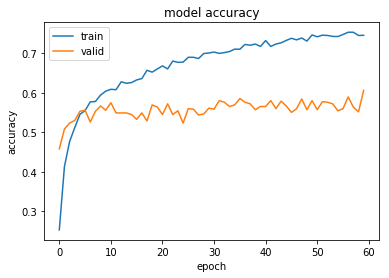

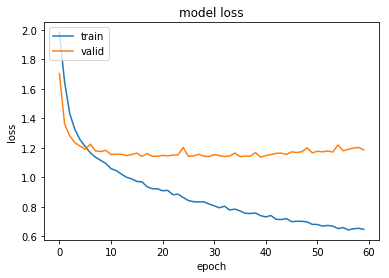

800/986 [=======================>......] - ETA:  - ETA: 0s

In [30]:
model = train_nn_model(model, train_set, encoded_y, filename = 'try(win2)load.h5')
y_predict = model.predict_proba(test_set)

In [11]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

In [12]:
y_predict, y_predict2 = xgbclassifier(train_set, train_y, test_set, 1, 8, 1000)

[0]	train-mlogloss:2.12103	valid-mlogloss:2.1398
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.08195	valid-mlogloss:1.41429
[50]	train-mlogloss:0.635513	valid-mlogloss:1.14206
[75]	train-mlogloss:0.39622	valid-mlogloss:1.02263
[100]	train-mlogloss:0.266812	valid-mlogloss:0.9639
[125]	train-mlogloss:0.190721	valid-mlogloss:0.934005
[150]	train-mlogloss:0.135582	valid-mlogloss:0.923324
[175]	train-mlogloss:0.099365	valid-mlogloss:0.923035
[200]	train-mlogloss:0.075394	valid-mlogloss:0.92593
[225]	train-mlogloss:0.057861	valid-mlogloss:0.930044
[250]	train-mlogloss:0.04554	valid-mlogloss:0.938324
Stopping. Best iteration:
[171]	train-mlogloss:0.104246	valid-mlogloss:0.922356

final validation loss:
0.922356043781
final validation accuracy:
0.676691729323


In [13]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin2load.csv")

In [14]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin2loadnolimit.csv")